## Importing libraries

In [181]:
import quandl
import nasdaqdatalink
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px
import statsmodels.api as sm 
import os
import warnings
import nasdaqdatalink
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

## Importing data from Nasdaq

In [182]:
# Configuring API key

nasdaqdatalink.ApiConfig.api_key = "zrm8zQsS-ZQa9eBQ5d9P"

In [183]:
# Importing World Bank Data from Nasdaq databases (https://data.nasdaq.com/databases/WB)

# Selecting Inflation and R&D spending, and the 10 countries I have in my original Startups dataset

In [184]:
countries = ["CAN","GBR","USA","FRA","JPN","CHN","AUS","BRA","IND","DEU"]
series_ids = {
    "Inflation": "FP.CPI.TOTL.ZG",
    "R&D Spending": "GB.XPD.RSDV.GD.ZS"
}

dfs = []

for name, series in series_ids.items():
    for country in countries:
        inflation_rd_dataset_temp = nasdaqdatalink.get_table(
            "WB/DATA",
            series_id=series,
            country_code=country
        )
        inflation_rd_dataset_temp["indicator"] = name
        inflation_rd_dataset_temp["country_code"] = country
        dfs.append(inflation_rd_dataset_temp)
        time.sleep(30)

inflation_rd_dataset = pd.concat(dfs, ignore_index=True)

In [185]:
inflation_rd_dataset.head(20)

,series_id,country_code,country_name,year,value,indicator
0,FP.CPI.TOTL.ZG,CAN,Canada,2023,3.879002,Inflation
1,FP.CPI.TOTL.ZG,CAN,Canada,2022,6.802801,Inflation
2,FP.CPI.TOTL.ZG,CAN,Canada,2021,3.395193,Inflation
3,FP.CPI.TOTL.ZG,CAN,Canada,2020,0.717000,Inflation
4,FP.CPI.TOTL.ZG,CAN,Canada,2019,1.949269,Inflation
5,FP.CPI.TOTL.ZG,CAN,Canada,2018,2.268226,Inflation
6,FP.CPI.TOTL.ZG,CAN,Canada,2017,1.596884,Inflation
7,FP.CPI.TOTL.ZG,CAN,Canada,2016,1.428760,Inflation
8,FP.CPI.TOTL.ZG,CAN,Canada,2015,1.125241,Inflation
9,FP.CPI.TOTL.ZG,CAN,Canada,2014,1.906636,Inflation


In [186]:
# Pivoting table to create two diff. columns for Inflation and R&D

inflation_rd_dataset_ordered = inflation_rd_dataset.pivot_table(
    index=["year", "country_code", "country_name"], 
    columns="indicator", 
    values="value"
).reset_index()

In [187]:
inflation_rd_dataset_ordered.head()

indicator,year,country_code,country_name,Inflation,R&D Spending
0,1960,AUS,Australia,3.728814,NaN
1,1960,CAN,Canada,1.358696,NaN
2,1960,DEU,Germany,1.536612,NaN
3,1960,FRA,France,4.139936,NaN
4,1960,GBR,United Kingdom,1.003576,NaN


## Subsetting, wrangling, and cleaning time-series data

In [188]:
inflation_rd_dataset_ordered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 592 entries, 0 to 591
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          592 non-null    int64  
 1   country_code  592 non-null    object 
 2   country_name  592 non-null    object 
 3   Inflation     592 non-null    float64
 4   R&D Spending  242 non-null    float64
dtypes: float64(2), int64(1), object(2)
memory usage: 23.3+ KB


In [189]:
# Normalizing columns' names

inflation_rd_dataset_ordered = inflation_rd_dataset_ordered.rename(columns={
    "Inflation": "inflation",
    "R&D Spending": "r&d"
})

In [190]:
inflation_rd_dataset_ordered.head()

indicator,year,country_code,country_name,inflation,r&d
0,1960,AUS,Australia,3.728814,NaN
1,1960,CAN,Canada,1.358696,NaN
2,1960,DEU,Germany,1.536612,NaN
3,1960,FRA,France,4.139936,NaN
4,1960,GBR,United Kingdom,1.003576,NaN


In [191]:
inflation_rd_dataset_ordered.describe()

indicator,year,inflation,r&d
count,592.000000,592.000000,242.000000
mean,1993.106419,23.898426,1.992616
std,18.188536,184.588616,0.769997
min,1960.000000,-7.633948,0.563240
25%,1978.000000,1.775090,1.531587
50%,1994.000000,3.291156,2.054260
75%,2009.000000,6.378498,2.598885
max,2023.000000,2947.732772,3.467770


In [192]:
# Checking duplicates

duplicates = inflation_rd_dataset_ordered.duplicated().sum()

In [193]:
duplicates

np.int64(0)

In [194]:
# Checking nulls

nulls = inflation_rd_dataset_ordered.isnull().sum()

In [195]:
nulls

indicator
year              0
country_code      0
country_name      0
inflation         0
r&d             350
dtype: int64

In [196]:
# Nulls by country (r&d)

nulls_by_country = inflation_rd_dataset_ordered[inflation_rd_dataset_ordered["r&d"].isnull()] \
    .groupby("country_name").size().reset_index(name="null_count")

In [197]:
nulls_by_country

,country_name,null_count
0,Australia,51
1,Brazil,22
2,Canada,37
3,China,11
4,France,38
5,Germany,38
6,India,39
7,Japan,38
8,United Kingdom,38
9,United States,38


In [198]:
# Nulls by year (r&d)

nulls_by_year = inflation_rd_dataset_ordered[inflation_rd_dataset_ordered["r&d"].isnull()] \
    .groupby("year").size().reset_index(name="null_count")

In [199]:
nulls_by_year

,year,null_count
0,1960,8
1,1961,8
2,1962,8
3,1963,8
4,1964,8
5,1965,8
6,1966,8
7,1967,8
8,1968,8
9,1969,8


In [200]:
nulls_by_country

,country_name,null_count
0,Australia,51
1,Brazil,22
2,Canada,37
3,China,11
4,France,38
5,Germany,38
6,India,39
7,Japan,38
8,United Kingdom,38
9,United States,38


In [201]:
# Looking for countries with no nulls from 2000 to 2020

df_filtered = inflation_rd_dataset_ordered[
    (inflation_rd_dataset_ordered["year"] >= 2000) & 
    (inflation_rd_dataset_ordered["year"] <= 2020)
]
countries_no_nulls = df_filtered.groupby("country_name")["r&d"].apply(lambda x: x.notnull().all())
countries_no_nulls = countries_no_nulls[countries_no_nulls].index.tolist()

In [202]:
countries_no_nulls

['Brazil',
 'Canada',
 'China',
 'France',
 'Germany',
 'India',
 'Japan',
 'United Kingdom',
 'United States']

In [203]:
# Exploring nulls for Australia

# Filtrar Australia
australia_nulls = inflation_rd_dataset_ordered[
    (inflation_rd_dataset_ordered["country_name"] == "Australia") &
    (inflation_rd_dataset_ordered["r&d"].isnull())
]["year"]

# Convertir a dataframe con conteo por año (aunque normalmente habrá solo 0 o 1 null por año)
nulls_by_year_australia = australia_nulls.value_counts().sort_index().reset_index()
nulls_by_year_australia.columns = ["year", "null_count"]

nulls_by_year_australia

,year,null_count
0,1960,1
1,1961,1
2,1962,1
3,1963,1
4,1964,1
5,1965,1
6,1966,1
7,1967,1
8,1968,1
9,1969,1


I can't use R&D data for Australia due to the nulls, but we can proceed with the other 9 countries for the analysis.

In [204]:
# Creating a new subset without Australia

inflation_rd_subset_without_australia = inflation_rd_dataset_ordered[
    inflation_rd_dataset_ordered["country_name"] != "Australia"
].reset_index(drop=True)

In [205]:
# Changing Year datatype

inflation_rd_subset_without_australia['year'] = inflation_rd_subset_without_australia['year'].astype(int)

In [206]:
# Checking outliers

inflation_rd_subset_without_australia.describe()

indicator,year,inflation,r&d
count,528.000000,528.000000,229.000000
mean,1993.301136,26.225110,1.995083
std,18.144012,195.343376,0.788651
min,1960.000000,-7.633948,0.563240
25%,1978.000000,1.747321,1.373690
50%,1994.000000,3.285243,2.061170
75%,2009.000000,6.357128,2.637150
max,2023.000000,2947.732772,3.467770


In [207]:
# Creating a new subset with data just from 2000 to 2020

inflation_rd_subset_without_australia = inflation_rd_subset[
    (inflation_rd_subset["year"] >= 2000) & 
    (inflation_rd_subset["year"] <= 2020)
].reset_index(drop=True)

In [208]:
inflation_rd_subset_without_australia.head()

indicator,year,country_code,country_name,inflation,r&d
0,2000,BRA,Brazil,7.044141,1.04751
1,2000,CAN,Canada,2.719440,1.85848
2,2000,CHN,China,0.347811,0.89316
3,2000,DEU,Germany,1.440268,2.40982
4,2000,FRA,France,1.675960,2.09346


In [209]:
inflation_rd_subset_without_australia.describe()

indicator,year,inflation,r&d
count,189.000000,189.000000,189.000000
mean,2010.000000,2.606136,2.007288
std,6.071384,2.517319,0.786576
min,2000.000000,-1.352837,0.646360
25%,2005.000000,1.127603,1.368540
50%,2010.000000,1.983857,2.051510
75%,2015.000000,3.392747,2.672840
max,2020.000000,14.714920,3.467770


Initial Analysis and Observations:

- The dataset has been cleaned and standardized for 9 of the 10 countries, excluding Australia due to a high number of missing values in the R&D column. Australia can still be considered for inflation analysis if needed.

- Data spans the period from 2000 to 2020 to avoid nulls

Inflation Data:

- Mean inflation is 2.6%, which aligns with expected values for the selected countries.

- Standard deviation is moderate at 2.5%, indicating reasonable variability.

- Min value of -1.3% likely reflects deflation in certain country-year observations.

- Max value of 14.7% suggests the presence of outliers that should be examined in subsequent steps.

R&D Data:

- Mean is approximately 2%, consistent across countries.

- No extreme outliers are immediately apparent, though a deeper country-by-country inspection may be useful.

## Visualizing data

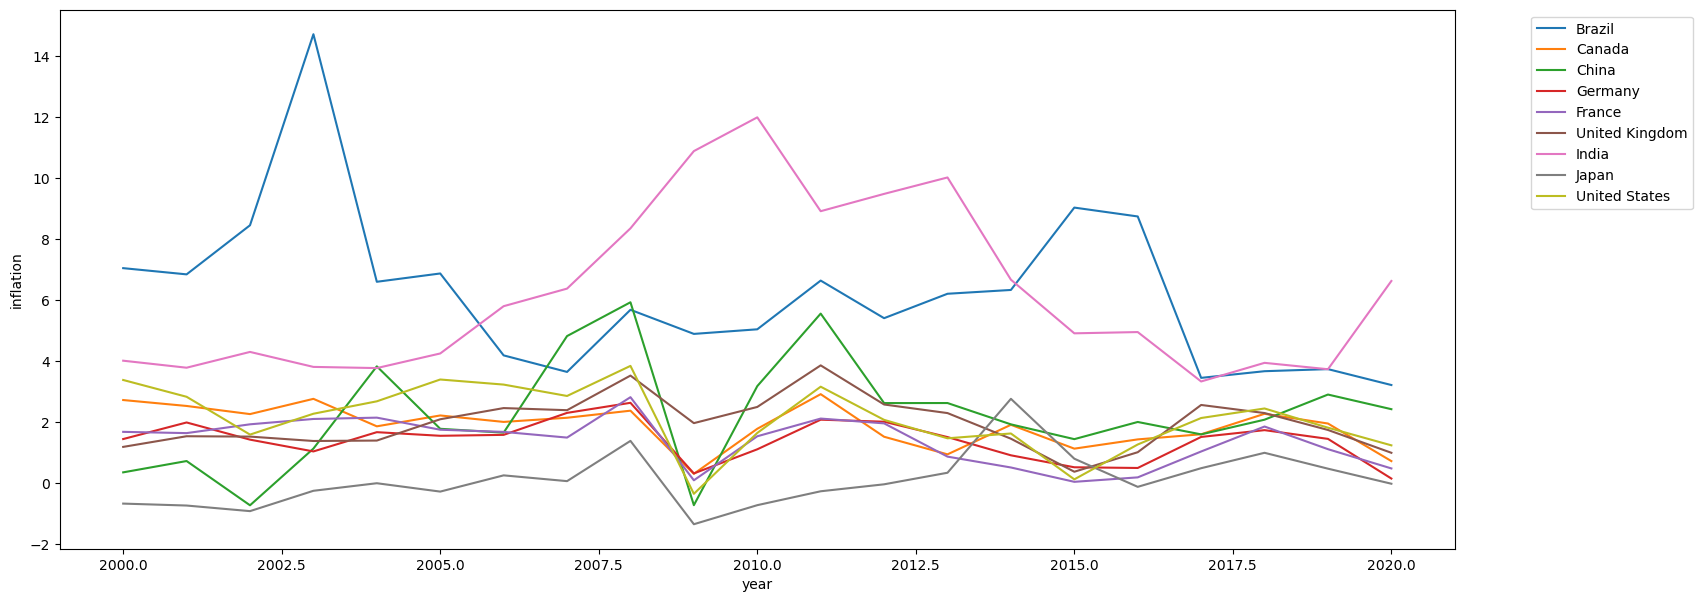

In [210]:
# Evolution of Inflation by country

sns.lineplot(data=inflation_rd_subset_without_australia, x='year', y='inflation', hue='country_name')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Coloca la leyenda fuera a la derecha
plt.show()

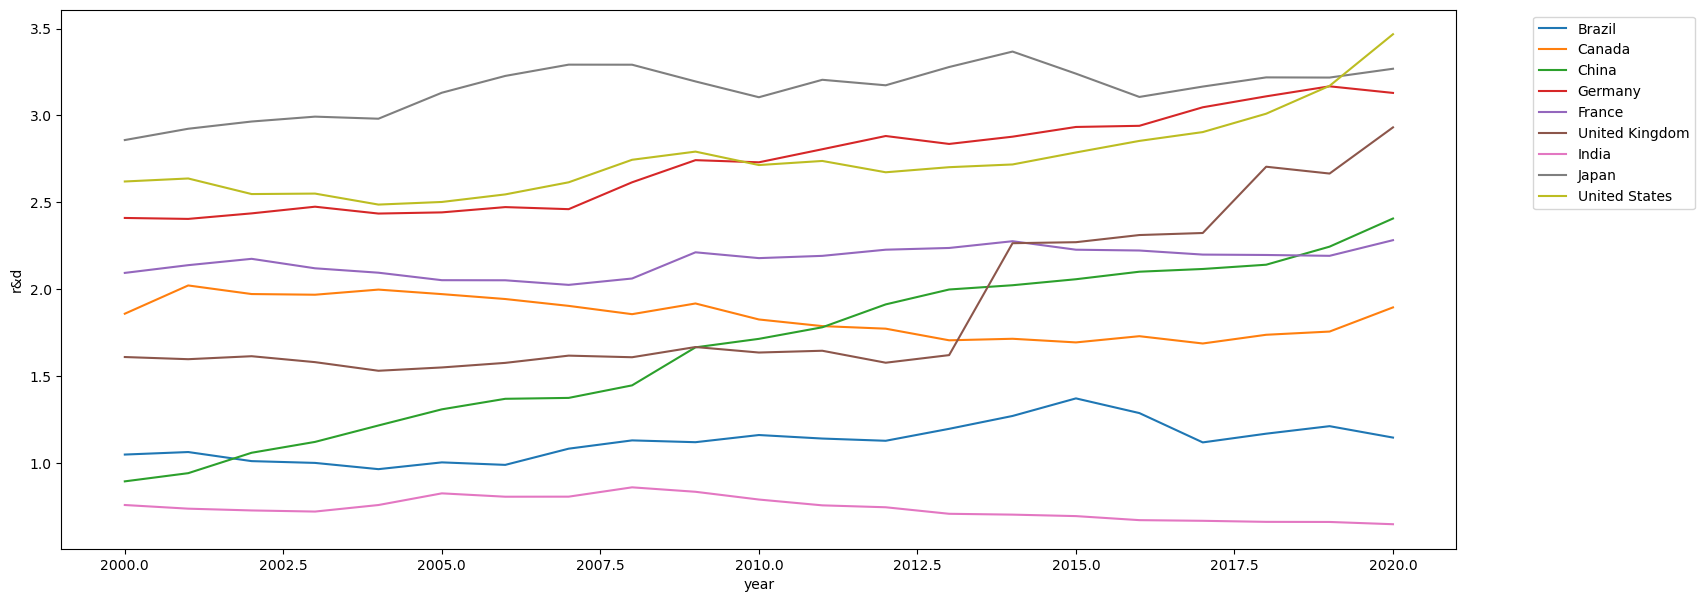

In [211]:
# Evolution of R&D by country

sns.lineplot(data=inflation_rd_subset_without_australia, x='year', y='r&d', hue='country_name')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [212]:
# Inflation and R&D distribution

inflation_rd_subset_without_australia_combined = inflation_rd_subset_without_australia.melt(
    id_vars=['year', 'country_code', 'country_name'],
    value_vars=['inflation', 'r&d'],
    var_name='indicator',
    value_name='value'
)

fig = px.box(
    inflation_rd_subset_without_australia_combined,
    x='indicator',
    y='value',
    color='indicator',
    points='all',            
    hover_data=['country_name', 'year'] 
)

fig.show()

Brazil and India are the main outliers in the inflation data, while Japan and China exhibit occasional years of deflation. Regarding R&D spending, the data shows a fairly consistent pattern across all countries.

## Preparing data for time series analysis

Taking into account the data, we can prepare diff. data sets for further analysis:

- R&D data from 2000 to 2020 with 9 countries excluding Australia.
- Inflation data from 1960 to 2020 for the 10 countries (Australia, Brazil, Canada, China, Germany, France, UK, India, Japan, and the U.S)

In [213]:
# Creating Inflation subset with only the needed columns

inflation_subset = inflation_rd_dataset_ordered[['year', 'country_name', 'inflation']].copy()

In [214]:
inflation_subset.head()

indicator,year,country_name,inflation
0,1960,Australia,3.728814
1,1960,Canada,1.358696
2,1960,Germany,1.536612
3,1960,France,4.139936
4,1960,United Kingdom,1.003576


In [215]:
inflation_subset.shape

(592, 3)

In [216]:
inflation_subset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 592 entries, 0 to 591
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          592 non-null    int64  
 1   country_name  592 non-null    object 
 2   inflation     592 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 14.0+ KB


In [217]:
inflation_subset.describe()

indicator,year,inflation
count,592.000000,592.000000
mean,1993.106419,23.898426
std,18.188536,184.588616
min,1960.000000,-7.633948
25%,1978.000000,1.775090
50%,1994.000000,3.291156
75%,2009.000000,6.378498
max,2023.000000,2947.732772


## Time Series Analysis (Inflation dataset)

We can start by analyzing each country's data, starting with Germany

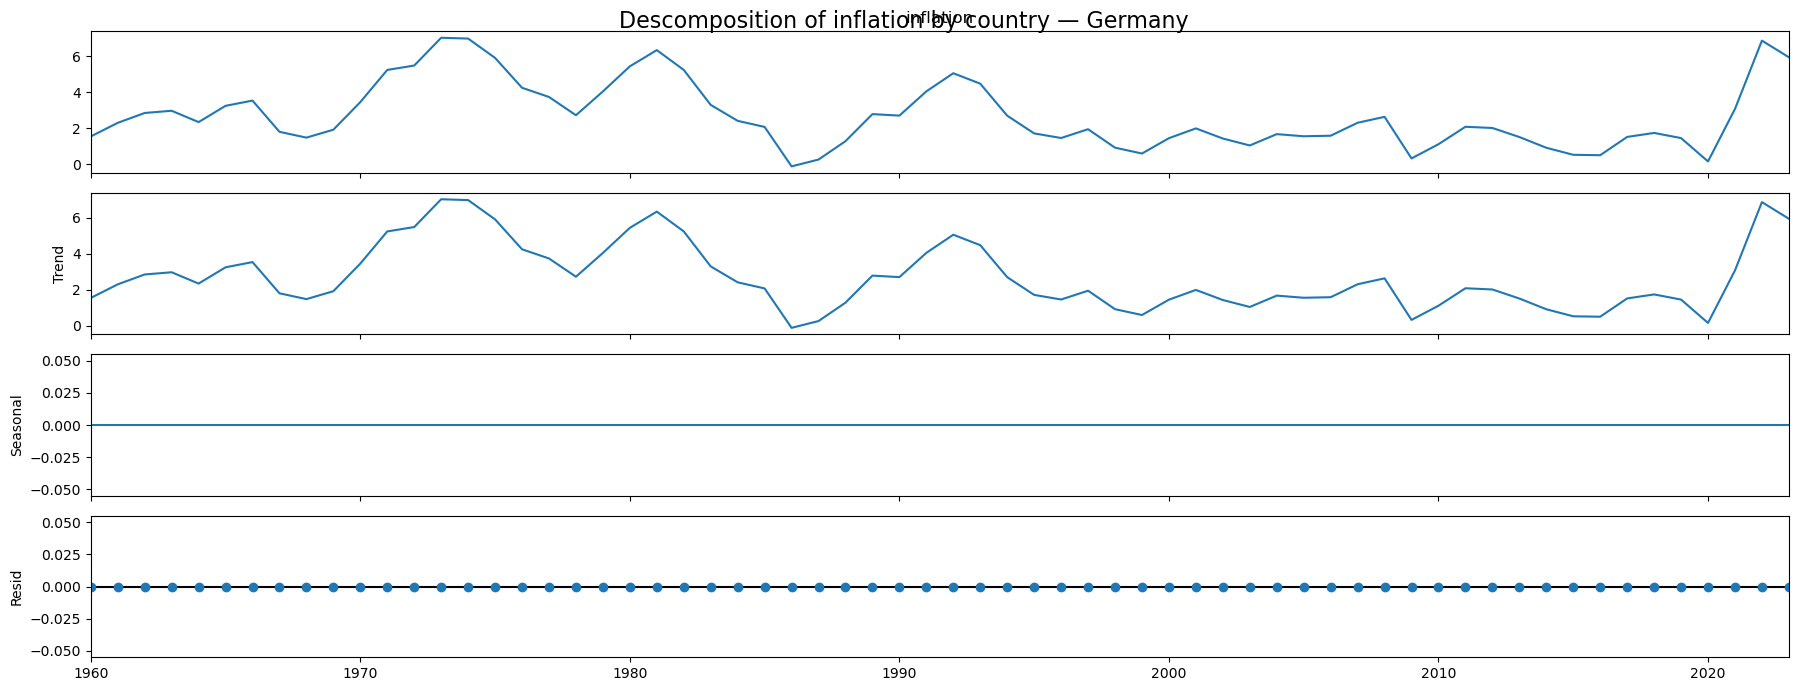

In [218]:
ts_germany_inflation = (
    inflation_subset[inflation_subset['country_name'] == 'Germany']
    .sort_values('year')
    .set_index('year')['inflation']
)

decomposition = sm.tsa.seasonal_decompose(ts_germany_inflation, model='additive', period=1)

rcParams['figure.figsize'] = 18, 7

decomposition.plot()
plt.suptitle("Descomposition of inflation by country — Germany", fontsize=16)
plt.show()

## Dickey–Fuller function to check for stationary

In [219]:
# Dickey-Fuller test for inflation in Germany

ts_germany_inflation = (
    inflation_subset[inflation_subset['country_name'] == 'Germany']
    .set_index('year')['inflation'] 
    .sort_index()
)

dickey_fuller(ts_germany_inflation, "Germany")


--- Dickey-Fuller Stationarity test: Germany ---
Test Statistic                 -3.566052
p-value                         0.006444
Number of Lags Used             1.000000
Number of Observations Used    62.000000
Critical Value (1%)            -3.540523
Critical Value (5%)            -2.909427
Critical Value (10%)           -2.592314
dtype: float64


np.float64(0.006444212864008947)

The test statistic is lower than the 5% critical value, and the p-value is less than 0.05. The German inflation series is stationary.

## Check for data’s autocorrelations

<Figure size 1200x400 with 0 Axes>

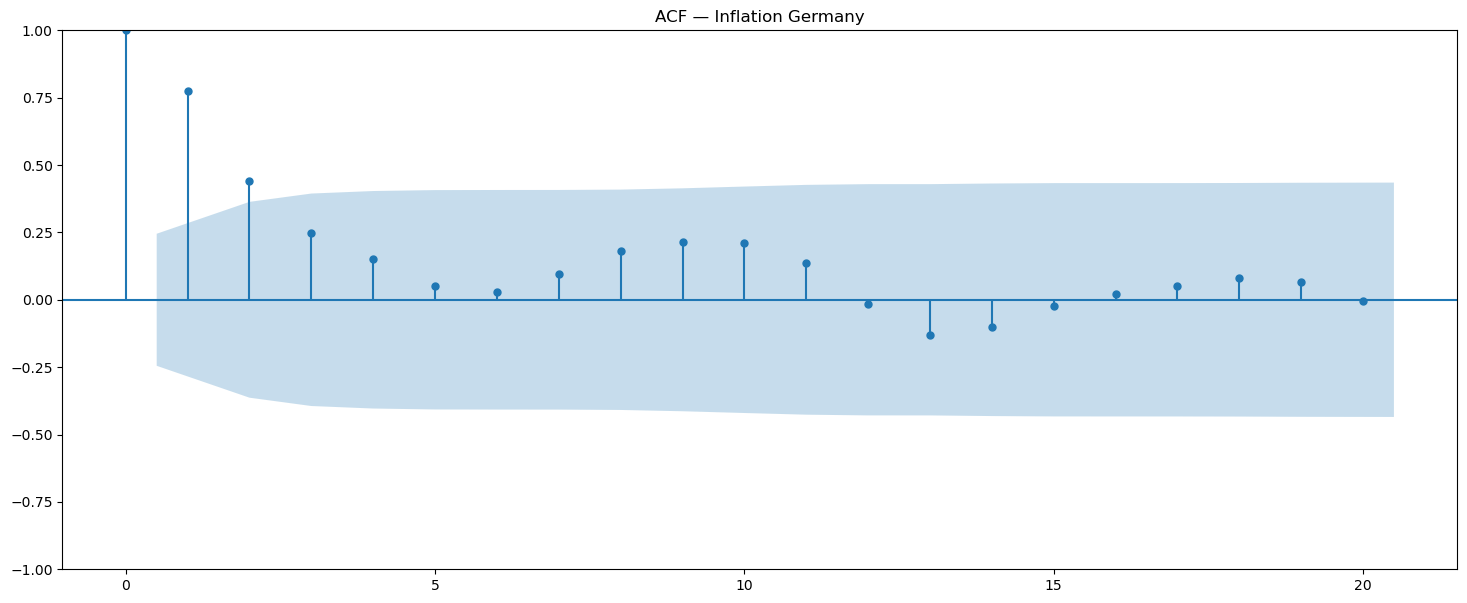

<Figure size 1200x400 with 0 Axes>

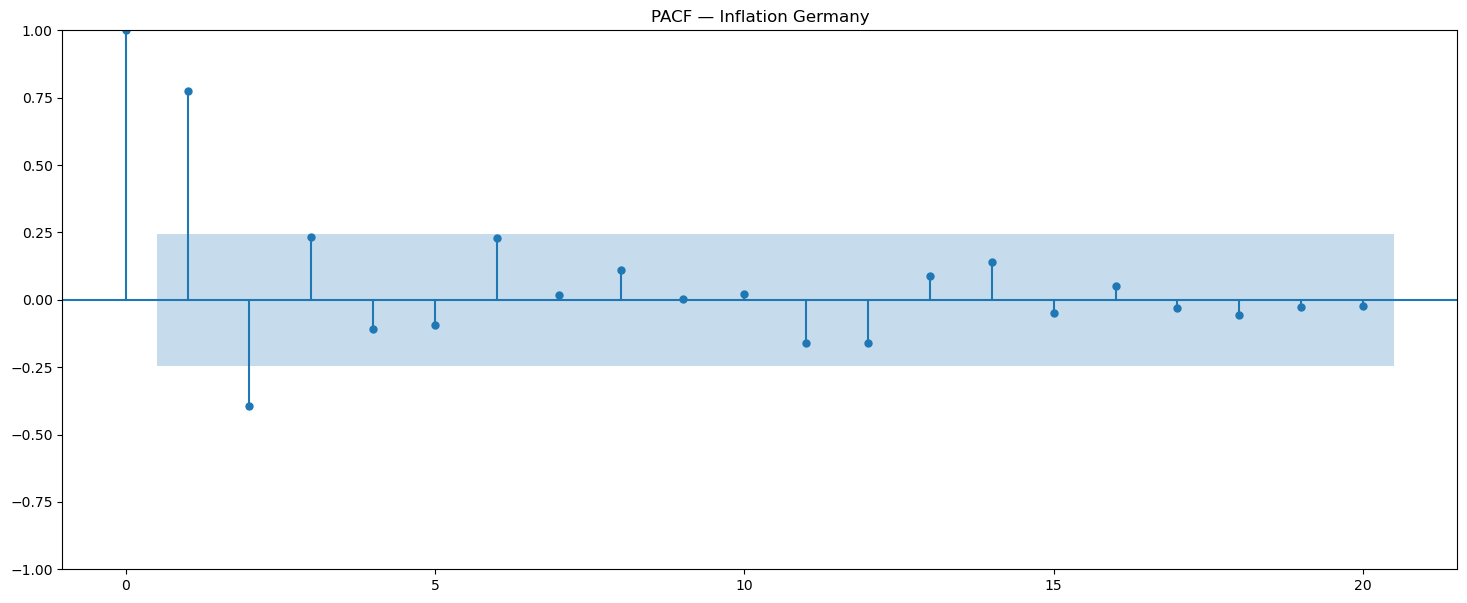

In [220]:
# ACF

plt.figure(figsize=(12,4))
plot_acf(ts_germany_inflation, lags=20, alpha=0.05)  # alpha=0.05 -> bandas de confianza
plt.title("ACF — Inflation Germany")
plt.show()


# PACF

plt.figure(figsize=(12,4))
plot_pacf(ts_germany_inflation, lags=20, method='ywm')
plt.title("PACF — Inflation Germany")
plt.show()

There is a strong initial correlation between both graphs, showing a high positive correlation around 0.75-1.0. This indicates that German inflation in one period is strongly correlated with inflation in the previous period. The blue area represents intervals, with most correlations beyond 3 falling within these bounds, indicating they aren't statistically significant.

This inflation series is stationary but without an obvious seasonal pattern. All in all, the German inflation data shows strong autoregressive behavior, where recent inflation values are determined by recent past values.

## Next steps

I will analyze the following data in order to cross it with the primary Startups dataset:
  
- Inflation data from 1960 to 2020 for the 10 countries: as I've done in this task, I can continue the analysis by country. In addition, I can combine all data to see if there is any correlation with funding or even valuation.

- R&D data from 2000 to 2020 with 9 countries excluding Australia: As for the inflation variable, analyzing R&D values by country can help to add some context to the data from the main Startups dataset.